In [2]:
import sys

sys.path.append('../src/')
import pytorch_lightning as pl
import glob
from pathlib import Path
from PIL import Image
import time
import cv2
import torch
import torchprof
import torch.autograd.profiler as profiler
import numpy as np
import matplotlib.pyplot as plt
from models.BiSeNetV2.bisenetv2 import BiSeNetV2
from models.utils import align_and_update_state_dicts
from configs.default import cfg
from thop import profile, clever_format
from train import LightningModel
from torchvision import transforms

In [13]:
cfg.merge_from_file('/home/squadx/projects/noaa_adapt/segmentation_ws/src/configs/bisenet_noaaice.yaml')

#model = BiSeNetV2(cfg)
model = LightningModel(cfg)

WARNING: As of 7/21/2020, loading the weights into the base BiSeNerV2 model using the helper function below results in a random network state that doesnt compute consistent results from one checkpoint load to the next

In [14]:
# BEST SO FAR
model_path = '/mnt/sandbox/models/noaa_adapt/full-res_adam_800sq_task1-5_ignore-mix/NOAA_ADAPT_ICEepoch=21-loss=0.48.ckpt'

checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

In [20]:
input_size = (3000, 2000) # w, h

raw_im = cv2.imread('/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_1_001_to_099-2020_07_07_23_36_21-coco-1.0/images/DSC00070.jpg')
label_im = cv2.imread('/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_1_001_to_099-2020_07_07_23_36_21-coco-1.0/label_images/DSC00070.png', cv2.IMREAD_UNCHANGED)
#raw_im = cv2.resize(raw_im, input_size)

image_norm = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

# These steps used in training
im = np.float32(raw_im).transpose([2,0,1])

im = image_norm(torch.tensor(im) / 255.0)

model_in = im.cuda().unsqueeze(0)
model = model.eval()
model = model.cuda()

In [27]:
# Export entire dirs to disk
src_dirs = {
    'Circle-sUAS-Visible-Responder-2017_05_05_afternoon_flight' : '/mnt/sandbox/projects/noaa_adapt/data/source/Circle-sUAS-Visible-Responder-2017_05_05_afternoon_flight-20200915T182259Z/Circle-sUAS-Visible-Responder-2017_05_05_afternoon_flight/100MSDCF/',
    'Circle-sUAS-Visible-Responder-2017_05_08_noon_flight' : '/mnt/sandbox/projects/noaa_adapt/data/source/Circle-sUAS-Visible-Responder-2017_05_08_noon_flight-20200915T190324Z/Circle-sUAS-Visible-Responder-2017_05_08_noon_flight/100MSDCF/'
}

save_dir = '/mnt/sandbox/projects/noaa_adapt/results/adam_500sq_task1-5_ignore-mix/'

cat_color_map = {
                    1 : (255,255,255),    # ice
                    2 : (0, 0, 255),      # water
                    3 : (200,200,200),    # ice-water-mix
                    4 : (42, 150, 42),    # land
                    5 : (200, 200, 255)   # snow-on-land
}

model = model.eval()
model = model.cuda()

image_norm = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

for src_dir, src_path in src_dirs.items():
    img_paths = glob.glob('{}/*.JPG'.format(src_path))
    for img_path in img_paths:
        raw_im = cv2.imread(img_path)
        im = np.float32(raw_im).transpose([2,0,1])
        im = image_norm(torch.tensor(im) / 255.0)
        model_in = im.cuda().unsqueeze(0)
    
        with torch.no_grad():
            out = model(model_in)[0] #There are 5 outputs from each stage for deep supervision during train
        labels = np.argmax(out.cpu().numpy()[0], axis=0) + 1
        
        result_img = np.zeros(raw_im.shape).astype(np.uint8)

        for label, color in cat_color_map.items():
            mask = labels == label
            result_img[mask] = color
            
        frame_name = img_path.split('/')[-1].split('.')[0]
        result_save_file = '{}/{}/segmentation_display/{}.png'.format(save_dir, src_dir, frame_name)
        mask_save_file = '{}/{}/segmentation_masks/{}.png'.format(save_dir, src_dir, frame_name)
            
        cv2.imwrite(result_save_file, np.uint8(result_img[:,:,::-1]))
        cv2.imwrite(mask_save_file, np.uint8(labels))


In [21]:
with torch.no_grad():
    out = model(model_in)[0] #There are 5 outputs from each stage for deep supervision during train
labels = np.argmax(out.cpu().numpy()[0], axis=0) + 1

(array([1, 2, 4]), array([ 2287367,  6420496, 15292137]))
(array([  1,   2,   3,   4, 255], dtype=uint8), array([2988172,  202220, 2241155,  506597,   61856]))


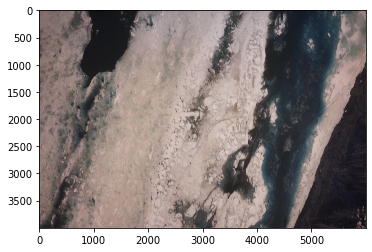

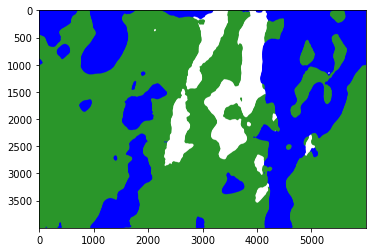

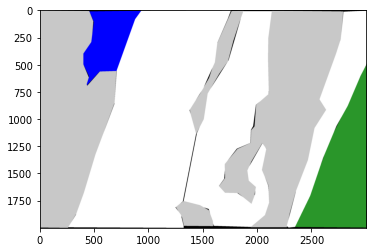

In [22]:
cat_color_map = {
                    1 : (255,255,255),    # ice
                    2 : (0, 0, 255),      # water
                    3 : (200,200,200),    # ice-water-mix
                    4 : (42, 150, 42),    # land
                    5 : (200, 200, 255)   # snow-on-land
}

result_img = np.zeros(raw_im.shape).astype(np.uint8)
label_disp_img = np.zeros((2000,3000,3)).astype(np.uint8)

#cv2.imwrite('/home/squadx/DSC00090_out.png', np.uint8(labels))
#cv2.imwrite('/home/squadx/DSC00090_gt.png', np.uint8(label_im))


for label, color in cat_color_map.items():
    mask = labels == label
    result_img[mask] = color
    
    label_mask = label_im == label
    label_disp_img[label_mask] = color

print(np.unique(labels, return_counts=True))
print(np.unique(label_im, return_counts=True))

plt.imshow(raw_im)
plt.figure()
plt.imshow(np.uint8(result_img))
plt.figure()
plt.imshow(label_disp_img)

In [16]:
out.cpu().numpy()[0][:,2500, 100]

array([ -2.4449399,   1.7102157, -14.97158  ,   0.6479669,  -1.0219789],
      dtype=float32)

In [ ]:
model = model.eval()
model = model.cuda()

src_path = Path('/mnt/sandbox/projects/noaa_adapt/data/task_blocks/')
save_dir = '/mnt/sandbox/projects/noaa_adapt/models/bisenet/baseline/val/'

file_paths = sorted(list(glob.glob('/mnt/sandbox/projects/noaa_adapt/data/chips_500sq/val/images/*.png')))
val_image_ids = np.unique([filepath.split('/')[-1].split('_')[0] for filepath in file_paths])
for val_image_id in val_image_ids:
    img_path = list(src_path.rglob('images/{}*'.format(val_image_id)))[0]    
    
    raw_im = cv2.imread(str(img_path))
    raw_im = cv2.resize(raw_im, input_size)

    image_norm = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

    # These steps used in training
    im = np.float32(raw_im).transpose([2,0,1])

    im = image_norm(torch.tensor(im) / 255.0)

    model_in = im.cuda().unsqueeze(0)

    with torch.no_grad():
        out = model(model_in)[0] #There are 5 outputs from each stage for deep supervision during train
        labels = np.argmax(out.cpu().numpy()[0], axis=0) + 1
       
    cv2.imwrite('{}/{}.png'.format(save_dir, val_image_id), labels)
    
    

In [ ]:
plt.figure(figsize=(24,72))
plt.imshow(np.concatenate([raw_im, result_img, label_disp_img], axis=1))

In [ ]:
# Benchmark
times = []
torch.backends.cudnn.benchmark = False
for ii in range(100):
    start = time.time()
    out = model(model_in)
    torch.cuda.synchronize()
    times.append(time.time() - start)
print('FPS: ', 1 / np.mean(times) )

In [ ]:
raw_im = cv2.imread('/home/squadx/projects/research/HRNet-Semantic-Segmentation/cityscapes_sample.jpg')
raw_im = cv2.resize(raw_im, (input_size[1], input_size[0]))

## Dataset Validation

In [ ]:
import imgaug.augmenters as iaa
from datasets.noaaice import NOAAICE
from configs.default import cfg
cfg.merge_from_file('/home/squadx/projects/noaa_adapt/segmentation_ws/src/configs/bisenet_noaaice.yaml')

In [ ]:
cfg.DATASET.PATH = '/mnt/sandbox/projects/noaa_adapt/data/chips_500sq/'

In [ ]:
cat_color_map = {
                    1 : (255,255,255),    # ice
                    2 : (0, 0, 255),      # water
                    3 : (200,200,200),    # ice-water-mix
                    4 : (42, 150, 42),    # land
                    5 : (200, 200, 255)   # snow-on-land
}

seq = iaa.Sequential([
                #iaa.Resize((self.cfg.TRAIN.INPUT_HEIGHT, self.cfg.TRAIN.INPUT_WIDTH)), 
                #iaa.Crop(percent=(0.0, 0.625)),
                iaa.Fliplr(0.5),
                iaa.Sharpen((0.0, 1.0)),       # sharpen the image
                iaa.Affine(rotate=(-45, 45)),  # rotate by -45 to 45 degrees (affects segmaps)
                #iaa.Dropout([0.05, 0.2]),      # drop 5% or 20% of all pixels
                #iaa.ElasticTransformation(alpha=50, sigma=5)  # apply water effect (affects segmaps)
            ]) 

dataset = NOAAICE(cfg.DATASET.PATH, trans_func=seq)


In [ ]:
img, labels = dataset.__getitem__(np.random.randint(0,len(dataset)))
img = img.cpu().numpy().transpose([1,2,0])
img -= img.min()

label_disp_img = np.zeros((500, 500, 3)).astype(np.uint8)

for label, color in cat_color_map.items():    
    label_mask = labels == label - 1
    label_disp_img[label_mask] = color
    
print(np.unique(labels+1, return_counts=True))
    
plt.imshow(np.uint8(img))
plt.figure()
plt.imshow(label_disp_img)

In [ ]:
mean = (0.225, 0.224, 0.229)
std = (0.225, 0.224, 0.229)
for ii in range(3):
    raw_im[ii] -= mean[ii]
    raw_im[ii] /= std[ii]

In [ ]:
chip_save_path = '/mnt/sandbox/projects/noaa_adapt/media/videos/DSC00097/frames/'
result_save_path = '/mnt/sandbox/projects/noaa_adapt/media/videos/DSC00097/frames_with_labels/'

offset = 0

for frame_id in range(120):
    chip = raw_im[frame_id*5:1080+frame_id*5, offset + frame_id*10: offset +1920 + frame_id*10, :]
    
    #raw_im = cv2.imread('/mnt/sandbox/projects/noaa_adapt/data/chips_500sq/val/images/DSC00099_00071.png')
    #label_im = cv2.imread('/mnt/sandbox/projects/noaa_adapt/data/chips_500sq/val/labels/DSC00099_00071.png', cv2.IMREAD_UNCHANGED)
    
    image_norm = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

    # These steps used in training
    im = np.float32(chip).transpose([2,0,1])

    im = image_norm(torch.tensor(im) / 255.0)

    model_in = im.cuda().unsqueeze(0)
    model = model.eval()
    model = model.cuda()
    
    with torch.no_grad():
        out = model(model_in)[0] #There are 5 outputs from each stage for deep supervision during train
    labels = np.argmax(out.cpu().numpy()[0], axis=0) + 1
    
    
    result_img = np.zeros(chip.shape).astype(np.uint8)

    for label, color in cat_color_map.items():
        mask = labels == label
        result_img[mask] = color
        
    combined = np.concatenate([chip, result_img], axis=1 )

    #cv2.imwrite('{}/frame_{}.png'.format(chip_save_path, str(frame_id).zfill(4)), chip)
    #cv2.imwrite('{}/frame_{}.png'.format(result_save_path, str(frame_id).zfill(4)), combined)
    Image.fromarray(chip).save('{}/frame_{}.png'.format(chip_save_path, str(frame_id).zfill(4)))
    Image.fromarray(combined).save('{}/frame_{}.png'.format(result_save_path, str(frame_id).zfill(4)))

    

In [ ]:
chip_save_path = '/mnt/sandbox/projects/noaa_adapt/media/videos/DSC00097/results/'

offset = 400

for frame_id in range(120):    
    chip = raw_im[frame_id*5:1080+frame_id*5, offset + frame_id*10: offset + 960 + frame_id*10, :]
    label_chip = result_img[frame_id*5:1080+frame_id*5, offset + frame_id*10: offset + 960 + frame_id*10, :]
    combined = np.concatenate([label_chip, chip], axis=1)
    
    Image.fromarray(combined).save('{}/frame_{}.png'.format(chip_save_path, str(frame_id).zfill(4)))

In [ ]:
chip_save_path = '/mnt/sandbox/projects/noaa_adapt/media/videos/DSC00099/results/'

for frame_id in range(110):    
    chip = raw_im[920:, 960 + frame_id*10: 960 + 960 + frame_id*10, :]
    label_chip = result_img[920:, frame_id*10: 960 + frame_id*10, :]
    combined = np.concatenate([label_chip, chip], axis=1)
    
    Image.fromarray(combined).save('{}/frame_{}.png'.format(chip_save_path, str(frame_id).zfill(4)))


In [ ]:
win_indices[np.logical_and((win_indices - 500) >= 0, (win_indices - 500) <= 1920)]

In [ ]:
resized_label_im[:, , :]

In [ ]:
# Sliding view
resized_raw_im = cv2.resize(raw_im, (1920,1080))
resized_label_im = cv2.resize(result_img, (1920, 1080))

chip_save_path = '/mnt/sandbox/projects/noaa_adapt/media/videos/DSC00099/results_slider/'

insert_width = 500
step_size = 10

resized_labels = cv2.resize(labels, (1920, 1080), interpolation=cv2.INTER_NEAREST)
cont_img = resized_raw_im.copy()

for label in range(1,6):
    contours, hierarchy = cv2.findContours(np.uint8(resized_labels == label), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cont_img = cv2.drawContours(cont_img, contours, -1, (255,0,0), 4)

win_indices = np.arange(1,insert_width+1) - insert_width

for frame_id in range(int((1920 + 500) / step_size) ):
        
    cols = win_indices[np.logical_and(win_indices >= 0, win_indices < 1920)]

    cont_cols = np.arange(0,np.min(cols))
    
    label_insert = resized_label_im[:, cols, :]
    frame = resized_raw_im.copy()
    frame[:, cols, :] = label_insert
    if len(cont_cols):
        frame[:, cont_cols, :] = cont_img[:, cont_cols, :]
    
    #Image.fromarray(frame).save('{}/frame_{}.png'.format(chip_save_path, str(frame_id).zfill(4)))

    win_indices += 10
    

In [ ]:
plt.imshow(frame)

In [ ]:
cont_img.shape

In [ ]:
np.count_nonzero(cont_img[:,:,0] == 255)

In [ ]:
np.count_nonzero(cont_img[:,:,0] == 255) / (cont_img.shape[0] * cont_img.shape[1])

In [ ]:
chip_save_path = '/mnt/sandbox/projects/noaa_adapt/media/videos/DSC00098/results/'

for frame_id in range(160):    
    chip = raw_im[920:, frame_id*10: 960 + frame_id*10, :]
    label_chip = result_img[920:, 250 + frame_id*10: 250 + 960 + frame_id*10, :]
    combined = np.concatenate([chip, label_chip], axis=1)
    
    Image.fromarray(combined).save('{}/frame_{}.png'.format(chip_save_path, str(frame_id).zfill(4)))


In [ ]:
resized_labels = cv2.resize(labels, (1920, 1080), interpolation=cv2.INTER_NEAREST)
contours, hierarchy = cv2.findContours(np.uint8(resized_labels), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cont_img = resized_raw_im.copy()
cont_img = cv2.drawContours(cont_img, contours, -1, (255,0,0), 4)

In [ ]:
plt.imshow(cont_img)

In [ ]:
contours

In [ ]:
[p.shape for p in model.parameters()]

In [ ]:
model